In [ ]:
# !pip3 install pandas openpyxl matplotlib

In [1]:
import pandas as pd
import os
import gzip
import json
from urllib.parse import urlparse, parse_qs, unquote
import re
import matplotlib.pyplot as plt

In [2]:
def parse_url(url):
    parsed_url = urlparse(url)
    params = parse_qs(parsed_url.query)
    
    # Extract the last directory of the URL path
    category = parsed_url.path.split('/')[-1]

    flat_params = {'category': category}
    for key, value in params.items():
        # Unquote the value to handle URL-encoded strings
        unquoted_value = unquote(value[0])
        
        # Try to load JSON data if present
        try:
            json_value = json.loads(unquoted_value)
            if isinstance(json_value, dict):
                # Flatten nested JSON
                for sub_key, sub_value in json_value.items():
                    flat_params[f"{key}.{sub_key}"] = sub_value
            else:
                flat_params[key] = json_value
        except json.JSONDecodeError:
            flat_params[key] = unquoted_value

    return flat_params

In [3]:
def parse_log_entry(entry):
    # Pattern for the main log entry structure
    main_pattern = r'\[pid: (\d+)\|app: (\d+)\|req: (\d+)/(\d+)\] (\d+\.\d+\.\d+\.\d+) \(\) \{(\d+) vars in (\d+) bytes\} \[(.*?)\] (\w+) (.*?) => generated (\d+) bytes in (\d+) msecs(?: via (.*?))? \((.*?)\) (\d+) headers in (\d+) bytes \((\d+) switches on core (\d+)\)'
    main_match = re.match(main_pattern, entry)

    # Pattern for Elasticsearch warning
    es_warning_pattern = r'WARNING:elasticsearch:(.*?) \[status:(\d+) request:(.*?)s\]'
    es_warning_match = re.match(es_warning_pattern, entry)

    # Pattern for general warnings and errors
    general_warning_pattern = r'(.*?):(\d+): (.*?):\n\n(.*?)\n\n(.*?)\n'
    general_warning_match = re.match(general_warning_pattern, entry)

    # Pattern for OSError
    oserror_pattern = r'OSError: (.*)'
    oserror_match = re.match(oserror_pattern, entry)

    # Pattern for SIGPIPE errors
    sigpipe_pattern = r'(\w+ \w+  \d+ \d+:\d+:\d+ \d+) - SIGPIPE: (.*?) on request (.*?) \(ip (.*?)\) !!!'
    sigpipe_match = re.match(sigpipe_pattern, entry)

    if main_match:
        return {
            'type': 'main',
            'pid': int(main_match.group(1)),
            'app': int(main_match.group(2)),
            'req_id': int(main_match.group(3)),
            'req_total': int(main_match.group(4)),
            'client_ip': main_match.group(5),
            'vars_count': int(main_match.group(6)),
            'vars_size': int(main_match.group(7)),
            'timestamp': main_match.group(8),
            'method': main_match.group(9),
            'endpoint': main_match.group(10),
            'response_size': int(main_match.group(11)),
            'response_time': int(main_match.group(12)),
            'via': main_match.group(13) if main_match.group(13) else '',
            'http_version_status': main_match.group(14),
            'headers_count': int(main_match.group(15)),
            'headers_size': int(main_match.group(16)),
            'switches': int(main_match.group(17)),
            'core': int(main_match.group(18))
        }
    elif es_warning_match:
        return {
            'type': 'es_warning',
            'message': es_warning_match.group(1),
            'status': int(es_warning_match.group(2)),
            'request_time': float(es_warning_match.group(3))
        }
    elif general_warning_match:
        return {
            'type': 'general_warning',
            'file': general_warning_match.group(1),
            'line': int(general_warning_match.group(2)),
            'warning_type': general_warning_match.group(3),
            'message': general_warning_match.group(4),
            'details': general_warning_match.group(5)
        }
    elif oserror_match:
        return {
            'type': 'os_error',
            'message': oserror_match.group(1)
        }
    elif sigpipe_match:
        return {
            'type': 'sigpipe_error',
            'timestamp': sigpipe_match.group(1),
            'error_message': sigpipe_match.group(2),
            'request': sigpipe_match.group(3),
            'client_ip': sigpipe_match.group(4)
        }
    else:
        return None

In [4]:
def process_spellbook_logs(log_file_path):
    # Reading the log file
    if log_file_path.endswith('.gz'):
        with gzip.open(log_file_path, 'rt') as file:
            log_entries = file.readlines()
    else:
        with open(log_file_path, 'r') as file:
            log_entries = file.readlines()

    # Parsing the log entries
    parsed_entries = [parse_log_entry(entry) for entry in log_entries if parse_log_entry(entry) is not None]

    # Creating a DataFrame from parsed entries
    df = pd.DataFrame(parsed_entries)

    # Handling missing 'endpoint' values
    df['endpoint'] = df['endpoint'].fillna('')

    # Filtering based on 'endpoint' contents
    df_api = df[df['endpoint'].str.contains('/api/generate_document')]
    df_web = df[df['endpoint'].str.contains('/download_generated_document')]

    # Debug statement to check the filtered DataFrames
    # print("df_api head:", df_api.head())
    # print("df_web head:", df_web.head())

    # Processing API and web DataFrames
    if not df_api.empty:
        df_api_processed = pd.DataFrame(df_api['endpoint'].apply(parse_url).tolist()).drop_duplicates()
    else:
        df_api_processed = pd.DataFrame(columns=['category', 'data.generation_date'])

    if not df_web.empty:
        df_web_processed = pd.DataFrame(df_web['endpoint'].apply(parse_url).tolist()).drop_duplicates()
    else:
        df_web_processed = pd.DataFrame(columns=['category', 'filename', 'download_name'])

    # Debug statements to check the content of the DataFrames
    # print("df_api_processed columns:", df_api_processed.columns)
    # print("df_api_processed head:", df_api_processed.head())
    # print("df_web_processed columns:", df_web_processed.columns)
    # print("df_web_processed head:", df_web_processed.head())

    # Check if the necessary columns exist in df_web_processed
    if 'filename' in df_web_processed.columns:
        df_web_processed['data.generation_date'] = df_web_processed['filename'].apply(lambda x: x.split(' ')[0])
    else:
        df_web_processed['data.generation_date'] = ''

    # Selecting relevant columns and adding 'type'
    if not df_api_processed.empty:
        df_api_processed = df_api_processed[['category', 'data.generation_date']]
        df_api_processed.loc[:, 'type'] = 'api'
    else:
        df_api_processed = pd.DataFrame(columns=['category', 'data.generation_date', 'type'])

    if not df_web_processed.empty:
        df_web_processed = df_web_processed[['category', 'data.generation_date']]
        df_web_processed.loc[:, 'type'] = 'web'
    else:
        df_web_processed = pd.DataFrame(columns=['category', 'data.generation_date', 'type'])

    # Combining the processed DataFrames
    output = pd.concat([df_api_processed, df_web_processed])

    # Generating the output CSV file name
    csv_file_name = os.path.splitext(log_file_path)[0] + '.csv'

    # Saving the DataFrame to a CSV file
    output.to_csv(csv_file_name, index=False)

    return output

# Processing all .log and .gz

In [ ]:
# Example usage:
log_file_path = 'all_logs/spellbook.log.12.gz'  # or 'all_logs/spellbook.log'
processed_df = process_spellbook_logs(log_file_path)
processed_df

# Merging ALL .csv's and generating the timeseries

In [16]:
def load_csv(file_path):
    return pd.read_csv(file_path)

In [17]:
def load_all_csv_files(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [load_csv(file) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [18]:
def generate_time_series_per_day(df):
    df['data.generation_date'] = pd.to_datetime(df['data.generation_date'])
    time_series = df.groupby([df['data.generation_date'].dt.date, 'category']).size().unstack(fill_value=0)
    return time_series

def generate_time_series_per_month(df):
    df['data.generation_date'] = pd.to_datetime(df['data.generation_date'])
    time_series = df.groupby([df['data.generation_date'].dt.to_period('M'), 'category']).size().unstack(fill_value=0)
    time_series.index = time_series.index.to_timestamp()  # Convert PeriodIndex to Timestamp for plotting
    return time_series

In [28]:
def plot_time_series(time_series, plot_mode='stacked_bar', time_series_mode='day'):
    # Set figure size based on time series mode
    if time_series_mode == 'day':
        fig, ax = plt.subplots(figsize=(12, 8))  # Larger size for daily graph
    elif time_series_mode == 'month':
        fig, ax = plt.subplots(figsize=(8, 6))  # Standard size for monthly graph

    if plot_mode == 'stacked_bar':
        time_series.plot(kind='bar', stacked=True, ax=ax)
    elif plot_mode == 'line':
        time_series.plot(kind='line', ax=ax)
    else:
        raise ValueError(f"Unsupported plot mode: {plot_mode}")

    plt.xlabel('Date')
    plt.ylabel('Number of Documents')
    plt.title('Documents Generated')

    # Format x-axis labels
    if time_series_mode == 'day':
        plt.xticks(rotation=90)
    elif time_series_mode == 'month':
        ax.set_xticklabels([x.strftime('%Y-%m') for x in time_series.index], rotation=90)

    plt.tight_layout()
    plt.legend(title='Category')
    plt.show()

Main

In [29]:
def process_csv_folder(folder_path, plot_mode='stacked_bar', time_series_mode='day'):
    # Load all CSV files into a combined DataFrame
    combined_df = load_all_csv_files(folder_path)
    
    # Generate the time series data
    if time_series_mode == 'day':
        time_series = generate_time_series_per_day(combined_df)
    elif time_series_mode == 'month':
        time_series = generate_time_series_per_month(combined_df)
    else:
        raise ValueError(f"Unsupported time series mode: {time_series_mode}")
    
    # Plot the time series data
    plot_time_series(time_series, plot_mode, time_series_mode)
    
    return combined_df, time_series

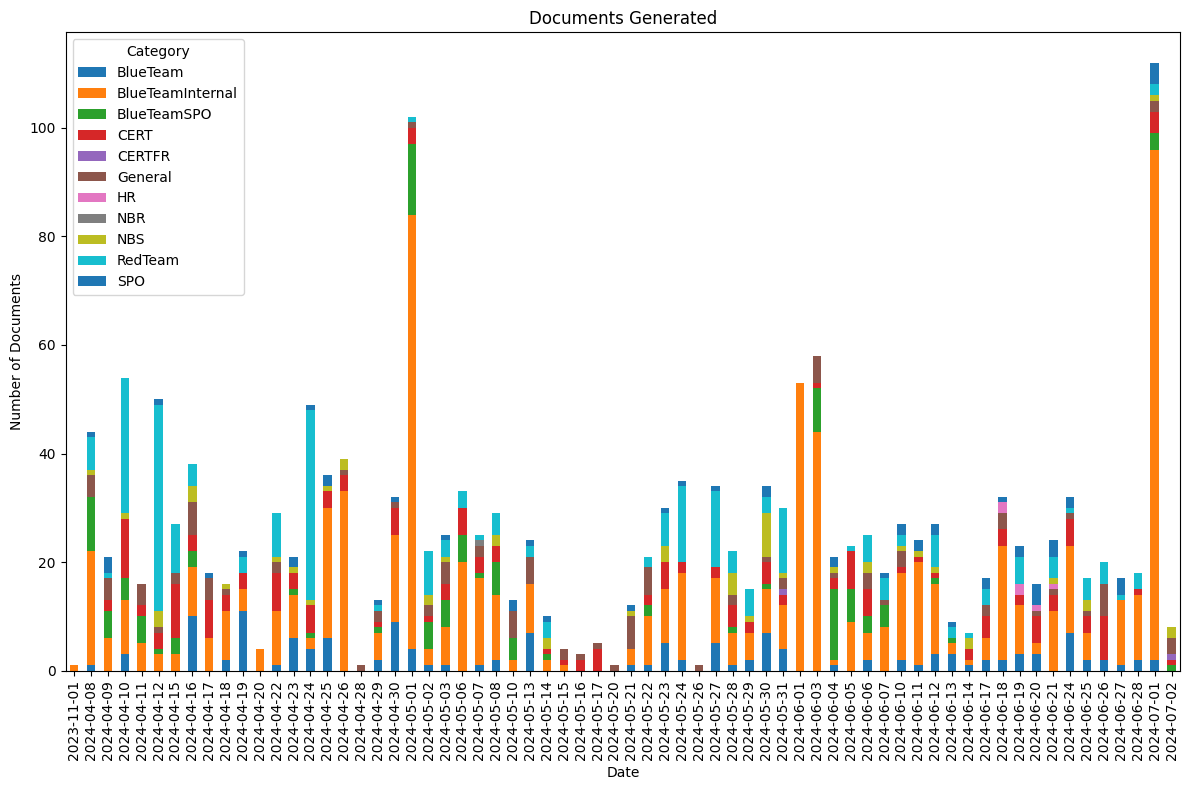

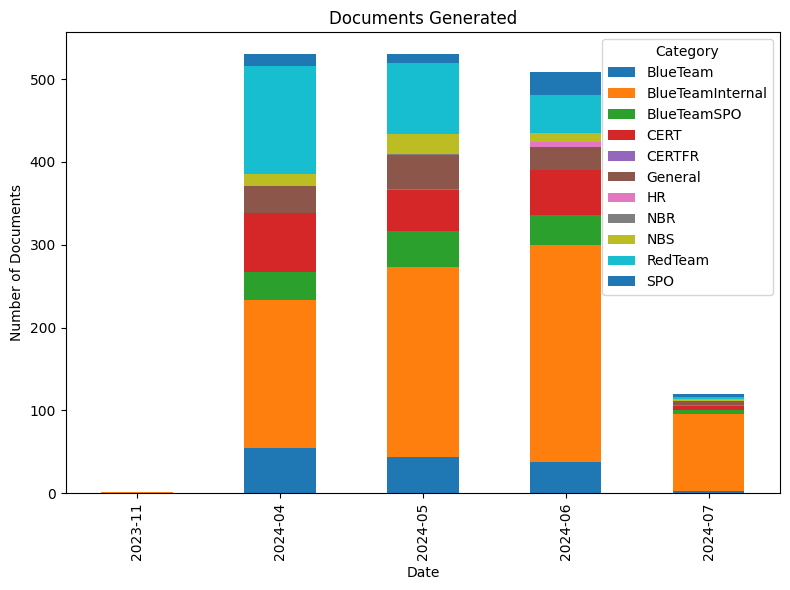

In [30]:
folder_path = 'all_logs/'
combined_df, time_series = process_csv_folder(folder_path, plot_mode='stacked_bar', time_series_mode='day')  # For per day
combined_df, time_series = process_csv_folder(folder_path, plot_mode='stacked_bar', time_series_mode='month')  # For per month